<a href="https://colab.research.google.com/github/Willgnner-Santos/ResNet34-PetriSegmentation/blob/main/ResNet34_PetriSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.2 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 
     |████████████████████████████████| 376 kB 44.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=3513c9f7d6502678671732b405e38268642082f8d8055cb43a58059fef1a322e
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=1f40e10df50d807edcd398a4ca5779851ebccd6df80bdd02fbdaa0c217b4d354
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
!nvidia-smi

Mon Jan 31 23:05:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Halos/Halos.zip -d ./

Archive:  /content/gdrive/MyDrive/Halos/Halos.zip
   creating: ./Halos/Original_images/
  inflating: ./Halos/Original_images/1.jpg  
  inflating: ./Halos/Original_images/10.jpg  
  inflating: ./Halos/Original_images/11.jpg  
  inflating: ./Halos/Original_images/12.jpg  
  inflating: ./Halos/Original_images/13.jpg  
  inflating: ./Halos/Original_images/14.jpg  
  inflating: ./Halos/Original_images/15.jpg  
  inflating: ./Halos/Original_images/16.jpg  
  inflating: ./Halos/Original_images/17.jpg  
  inflating: ./Halos/Original_images/18.jpg  
  inflating: ./Halos/Original_images/19.jpg  
  inflating: ./Halos/Original_images/2.jpg  
  inflating: ./Halos/Original_images/20.jpg  
  inflating: ./Halos/Original_images/21.jpg  
  inflating: ./Halos/Original_images/22.jpg  
  inflating: ./Halos/Original_images/23.jpg  
  inflating: ./Halos/Original_images/24.jpg  
  inflating: ./Halos/Original_images/25.jpg  
  inflating: ./Halos/Original_images/26.jpg  
  inflating: ./Halos/Original_images/27.

## Imports necessários

In [ ]:
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import pandas as pd
from torchvision.io import read_image
import math
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [ ]:
import pandas as pd
from torchvision.io import read_image

class halosDataset(Dataset):
  def __init__(self, img_dir, mask_dir, transform=None):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.img_list = os.listdir(img_dir)
    self.lenght = len(self.img_list)

  def __len__(self):
    return self.lenght

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_list[idx])
    image = read_image(img_path)
    mask_path = os.path.join(self.mask_dir, self.img_list[idx])
    mask = read_image(mask_path)

    # Descartando o terceiro canal de cor (somente preto)
    mask = mask[:2]

    # Aplicando transformações nas imagens (resize)
    if self.transform:
        image = self.transform(image)
        mask = self.transform(mask)

    # Aplicando threshhold nos canais
    mask[0][mask[0] > 127] = 255
    mask[0][mask[0] < 127] = 0
    mask[1][mask[1] > 127] = 255
    mask[1][mask[1] < 127] = 0

    # Normalizando a imagem e a máscara
    return image/255.0, mask/255.0

In [ ]:
import math
import torchvision
from torchvision import transforms

transfs = torch.nn.Sequential(
    transforms.Resize((256,256), interpolation=torchvision.transforms.InterpolationMode.NEAREST),
)


dataset = halosDataset('/content/Halos/Original_images','/content/Halos/ROI',transform=transfs)

lengths = [math.ceil(len(dataset)*0.8), int(len(dataset)*0.2)]
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, lengths)

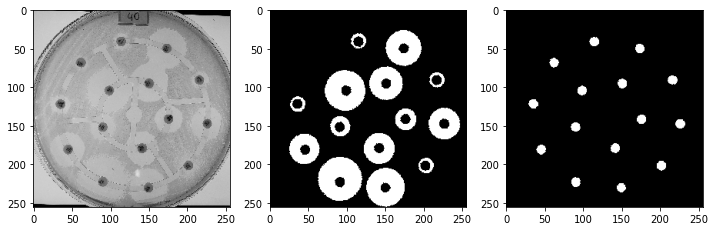

In [ ]:
import matplotlib.pyplot as plt

image1, mask1 = train_dataset[1]

plt.figure(figsize=((12,8)))

plt.subplot(1,3,1)
plt.imshow(image1[0], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(mask1[0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(mask1[1], cmap='gray')

In [ ]:
print(image1.shape, mask1.shape)

torch.Size([3, 256, 256]) torch.Size([2, 256, 256])


In [ ]:
np.histogram(mask1[1])

(array([63738,     0,     0,     0,    24,     0,     0,     0,     0,
         1774]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

## Criação do Data Loader

In [ ]:
# Carregador de dados com batch_size
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## Criação do modelo

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
model = smp.UnetPlusPlus('resnet34', classes = 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
DEVICE = 'cuda'

loss = smp.losses.FocalLoss(mode='multilabel')
loss.__name__ = 'focal_loss'
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# Modelo de treino para 100 épocas

max_score = 0

for i in range(0, 100):

    print('\nEpoch: {}'.format(i))
    results = train_logs = train_epoch.run(train_loader)
    results = valid_logs = valid_epoch.run(valid_loader)

    # Fazer algo (salvar modelo, alterar lr, etc)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Modelo salvo!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Diminua a taxa de aprendizagem do decodificador para 1e-5!')


Epoch: 0
valid: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, focal_loss - 0.4561, iou_score - 0.004192]
Modelo salvo!

Epoch: 1
valid: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, focal_loss - 0.1346, iou_score - 3.89e-13]

Epoch: 2
valid: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, focal_loss - 0.1176, iou_score - 0.003371]

Epoch: 3
valid: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, focal_loss - 0.3962, iou_score - 0.02443]
Modelo salvo!

Epoch: 4
valid: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, focal_loss - 0.1343, iou_score - 0.167]
Modelo salvo!

Epoch: 5
valid: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, focal_loss - 0.06911, iou_score - 0.6192]
Modelo salvo!

Epoch: 6
valid: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, focal_loss - 0.0588, iou_score - 0.4296]

Epoch: 7
valid: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, focal_loss - 0.04448, iou_score - 0.5572]

Epoch: 8
valid: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, focal_loss - 0.037, iou_score - 0.644]
Mo

In [ ]:
# Carregar o melhor ponto de verificação salvo
best_model = torch.load('./best_model.pth')

In [ ]:
imagem_ori, mask = next(iter(train_loader))
best_model.to('cpu')
best_model.eval()
mask_pred = best_model(imagem_ori)

In [ ]:
imagem_ori.shape

torch.Size([16, 3, 256, 256])

In [ ]:
sigmoid_batch = torch.sigmoid(mask_pred)
imagem1 = mask_pred[4].detach().numpy()

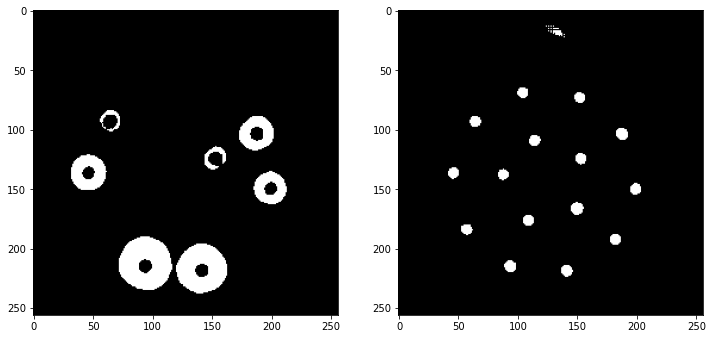

In [ ]:
THRESHHOLD_FINAL = .100

plt.figure(figsize=((12,8)))
# Discos
plt.subplot(1,2,1)
plt.imshow(imagem1[0] > THRESHHOLD_FINAL, cmap='gray')

# Halos
plt.subplot(1,2,2)
plt.imshow(imagem1[1] > THRESHHOLD_FINAL, cmap='gray')

In [ ]:
!cp /content/best_model.pth /content/gdrive/MyDrive/Halos

In [ ]:
np.histogram(imagem1[1])

(array([   26,   100,   257, 60580,  3196,   438,   353,   334,   208,
           44]),
 array([-4.7931433 , -3.9042003 , -3.0152576 , -2.1263146 , -1.2373718 ,
        -0.34842896,  0.5405139 ,  1.4294567 ,  2.3183997 ,  3.2073424 ,
         4.0962853 ], dtype=float32))

In [ ]:
import os
images = []

for filename in os.listdir("downloaded"):
    img = Image.open(os.path.join("downloaded", filename))
    img = img.resize((32, 32))
    plt.imshow(img)
    plt.show()
    img = np.array(img) / 255
    images.append(img)

In [ ]:
predictions = model.predict(images)


In [ ]:
fig, axs = plt.subplots(9, 2, figsize=(10, 25))
axs = axs.ravel()
for i in range(18):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(images[i // 2])
        axs[i].set_title("Prediction: %s" % id_to_name[np.argmax(predictions[i // 2])])

    else:
        axs[i].bar(np.arange(65), predictions[i // 2])
        axs[i].set_ylabel("Softmax")
        axs[i].set_xlabel("Labels")

plt.show()

In [ ]:
fig, axs = plt.subplots(9, 2, figsize=(10, 25))
axs = axs.ravel()
for i in range(18):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(images[i // 2])
        axs[i].set_title("Prediction: %s" % id_to_name[np.argmax(predictions[i // 2])])
        plt.imsave('"Prediction: %s" % id_to_name[np.argmax(predictions[i // 2])]',axs[i])

    else:
        axs[i].bar(np.arange(65), predictions[i // 2])
        axs[i].set_ylabel("Softmax")
        axs[i].set_xlabel("Labels")


plt.show()

In [ ]:
for i in range(len(images)*2):
        finalPrediction.append(id_to_name[np.argmax(predictions[i // 2])])
        plt.imsave(('testo/ {}.jpg'.format(str(i // 2)+id_to_name[np.argmax(predictions[i // 2])])),images[i // 2])